<a href="https://colab.research.google.com/github/carlm451/Gemstone_Images_Classification_Fine_Tuning/blob/main/Gemstones_Classifier_Model_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import os
import matplotlib.pyplot as plt
from random import shuffle 

#will use MobileNetV2... efficient pretrained model we can fine-tune easily 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


In [2]:
# pulling gemstones data from kaggle
#!pip install kaggle

!mkdir ~/.kaggle

#need a kaggle API key kaggle.json
!mv kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download lsind18/gemstones-images

 85% 47.0M/55.2M [00:00<00:00, 113MB/s] 
100% 55.2M/55.2M [00:00<00:00, 106MB/s]


In [5]:
!unzip gemstones-images.zip &> /dev/null  #suppress terminal output when unzipping images
!ls 

gemstones-images.zip  sample_data  test  train


In [6]:
#going to split of some of the training data for a validation data set
!mkdir val

In [7]:
import os

data_dir = '/content'

train_dir = os.path.join(data_dir,'train')

val_dir = os.path.join(data_dir,'val')

test_dir = os.path.join(data_dir,'test')

def count_img_samples(directory):
    
    count = 0
    
    for i,gem_type in enumerate(os.listdir(directory)):
        
        gem_dir = os.path.join(directory,gem_type)
    
        img_list = os.listdir(gem_dir)

        #print(f' dir {gem_dir} has {len(img_list)} images')

        count += len(img_list)
    
    return count

n_train = count_img_samples(train_dir)
n_test = count_img_samples(test_dir)
n_val = count_img_samples(val_dir)

print(f'{n_train=}, {n_val=}, {n_test=}')

n_train=2856, n_val=0, n_test=363


In [8]:
from random import shuffle

def partition_val_data(train_dir,val_dir,val_split=0.1):
    
    for gem_type in os.listdir(train_dir):
        
        train_gem_dir = os.path.join(train_dir,gem_type)
        
        img_list = os.listdir(train_gem_dir)
        
        shuffle(img_list)
        
        n_samples = round(len(img_list)*val_split)
        
        val_img_list = img_list[:n_samples] # take n_samples random images to move
        
        val_gem_dir = os.path.join(val_dir,gem_type)
        
        if not os.path.exists(val_gem_dir):
            
            os.mkdir(val_gem_dir)
            
            for gem_img in val_img_list:
                
                original_path = os.path.join(train_gem_dir,gem_img)
                
                destination_path = os.path.join(val_gem_dir,gem_img)
                
                os.rename(original_path,destination_path)
        
            print(f'Moved {len(os.listdir(val_gem_dir))} training images from to {val_gem_dir}')
            
        else:
            
            print(f'Val dir {val_gem_dir} has {len(os.listdir(val_gem_dir))} images')

In [9]:
val_split=0.15  # move 15% train to use for validation

partition_val_data(train_dir,val_dir,val_split)

Moved 4 training images from to /content/val/Spessartite
Moved 5 training images from to /content/val/Chrysoberyl
Moved 5 training images from to /content/val/Opal
Moved 6 training images from to /content/val/Citrine
Moved 5 training images from to /content/val/Iolite
Moved 4 training images from to /content/val/Zoisite
Moved 5 training images from to /content/val/Pearl
Moved 4 training images from to /content/val/Chrysoprase
Moved 5 training images from to /content/val/Amber
Moved 5 training images from to /content/val/Turquoise
Moved 5 training images from to /content/val/Danburite
Moved 5 training images from to /content/val/Spodumene
Moved 5 training images from to /content/val/Sapphire Blue
Moved 5 training images from to /content/val/Almandine
Moved 5 training images from to /content/val/Andradite
Moved 5 training images from to /content/val/Diaspore
Moved 7 training images from to /content/val/Aventurine Green
Moved 5 training images from to /content/val/Kunzite
Moved 4 training

In [10]:
!ls val

gem_types_list = os.listdir(val_dir)

n_classes = len(gem_types_list)

print(f'{n_classes} classes of gemstone')

 Alexandrite	      Chrysocolla     Larimar		 'Sapphire Blue'
 Almandine	      Chrysoprase     Malachite		 'Sapphire Pink'
 Amazonite	      Citrine	      Moonstone		 'Sapphire Purple'
 Amber		      Coral	      Morganite		 'Sapphire Yellow'
 Amethyst	      Danburite      'Onyx Black'	  Scapolite
 Ametrine	      Diamond	     'Onyx Green'	  Serpentine
 Andalusite	      Diaspore	     'Onyx Red'		  Sodalite
 Andradite	      Dumortierite    Opal		  Spessartite
 Aquamarine	      Emerald	      Pearl		  Sphene
'Aventurine Green'    Fluorite	      Peridot		  Spinel
'Aventurine Yellow'  'Garnet Red'     Prehnite		  Spodumene
 Benitoite	      Goshenite       Pyrite		  Sunstone
'Beryl Golden'	      Grossular       Pyrope		  Tanzanite
 Bixbite	      Hessonite      'Quartz Beer'	 'Tigers Eye'
 Bloodstone	      Hiddenite      'Quartz Lemon'	  Topaz
'Blue Lace Agate'     Iolite	     'Quartz Rose'	  Tourmaline
 Carnelian	      Jade	     'Quartz Rutilated'   Tsavorite
'Cats Eye'	      Jasper	     'Quartz 

In [11]:
from tensorflow.keras.utils import load_img, img_to_array

def get_img_array(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path)
    
    x = img_to_array(img) / 255.
    
    return x

def get_img_array_resized(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path,target_size=(224,224),keep_aspect_ratio=False)
    
    x = img_to_array(img) / 255.
    
    return x

In [ ]:
import matplotlib.pyplot as plt

shuffle(gem_types_list)

fig,axes=plt.subplots(6,6,figsize=(9,9))

count=0

for i in range(6):
  for j in range(6):

      gem_type=gem_types_list[count]

      sample_x = get_img_array(train_dir,gem_type)
      sample_x_resized = get_img_array_resized(train_dir,gem_type)

      axes[i,j].imshow(sample_x_resized)
      axes[i,j].set_axis_off()
      axes[i,j].set_title(f'{gem_type}')

plt.show()

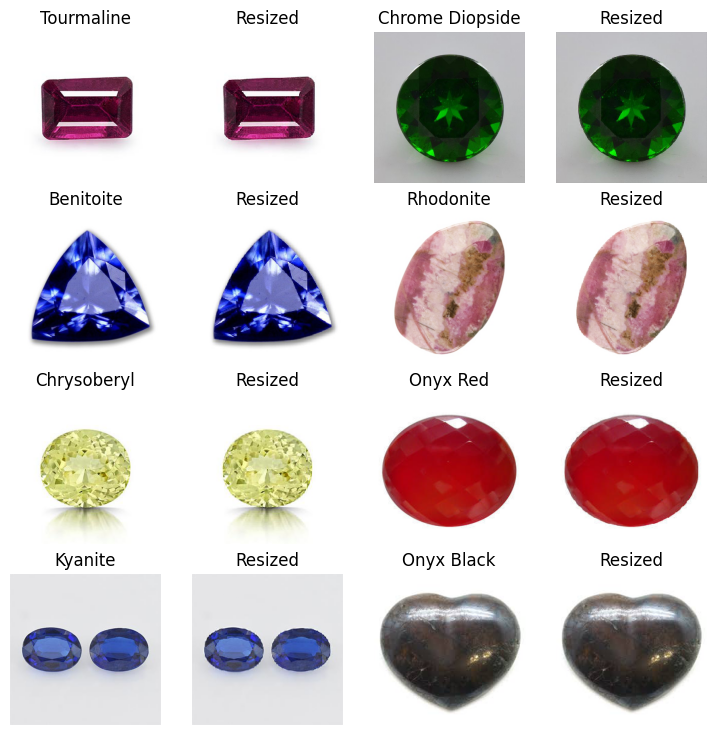

In [19]:
import matplotlib.pyplot as plt

shuffle(gem_types_list)

fig,axes=plt.subplots(4,4,figsize=(9,9))

count=0

for i in range(4):

  for j in range(0,4,2):

      gem_type=gem_types_list[count]

      sample_x = get_img_array(train_dir,gem_type)

      sample_x_resized = get_img_array_resized(train_dir,gem_type)

      axes[i,j].imshow(sample_x)
      axes[i,j].set_axis_off()
      axes[i,j].set_title(f'{gem_type}')

      axes[i,j+1].imshow(sample_x_resized)
      axes[i,j+1].set_axis_off()
      axes[i,j+1].set_title(f'Resized')

      count+=1

plt.show()

In [20]:
# generators to stream images for training/validation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   rotation_range=90,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   zoom_range=0.5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

val_datagen  = ImageDataGenerator( rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    keep_aspect_ratio=False,
                                                    classes=gem_types_list) 

val_generator = val_datagen.flow_from_directory(val_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    keep_aspect_ratio=False,
                                                    classes=gem_types_list) 

Found 2434 images belonging to 87 classes.
Found 422 images belonging to 87 classes.


In [21]:
def get_uncompiled_model(n_classes, model_name,fine_tune=0):

    tf.keras.backend.clear_session()

    pretrained = MobileNetV2(include_top=False, pooling='avg',input_shape=(224,224,3))

    if fine_tune > 0:
        for layer in pretrained.layers[:-fine_tune]:
            layer.trainable = False
    else:
        pretrained.trainable=False #freezes all children layers 

    inputs=tf.keras.layers.Input(shape=(224,224,3))

    x=pretrained(inputs,training=False)   #this is important for behavior of batch norm layers when fine-tuning

    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(n_classes)(x)  # make sure to use from_logits=True in loss later on

    model = tf.keras.Model(inputs=inputs,outputs=x)
    
    return model

In [22]:
model_1 = get_uncompiled_model(n_classes,model_name='mobilenetV2_frozen')
    
model_1.summary()

#checking that the input size is correct, should be (224,224,3)
model_1.input

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 87)                111447    
                                                                 
Total params: 2,369,431
Trainable params: 111,447
Non-trainable params: 2,257,984
_________________________________________________________________


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [24]:
model_1.layers[1].summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [27]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [28]:
!rm -r training_1

!mkdir training_1

In [29]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

N_EPOCHS=20

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

history_1 = model_1.fit(
            train_generator,
            epochs=N_EPOCHS,
            validation_data=val_generator,
            verbose=1,
            callbacks=[cp_callback]
            )

Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 3.7005 - categorical_accuracy: 0.1758
Epoch 1: saving model to training_1/cp-0001.ckpt
39/39 [==============================] - 53s 1s/step - loss: 3.7005 - categorical_accuracy: 0.1758 - val_loss: 2.3874 - val_categorical_accuracy: 0.3839
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 2.1274 - categorical_accuracy: 0.4318
Epoch 2: saving model to training_1/cp-0002.ckpt
39/39 [==============================] - 39s 1s/step - loss: 2.1274 - categorical_accuracy: 0.4318 - val_loss: 1.9512 - val_categorical_accuracy: 0.4810
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 1.7493 - categorical_accuracy: 0.5070
Epoch 3: saving model to training_1/cp-0003.ckpt
39/39 [==============================] - 41s 1s/step - loss: 1.7493 - categorical_accuracy: 0.5070 - val_loss: 1.8148 - val_categorical_accuracy: 0.5118
Epoch 4/20
39/39 [==============================] - ETA: 0s - loss: 1.5837 -

Text(0.5, 1.0, 'Training and validation loss')

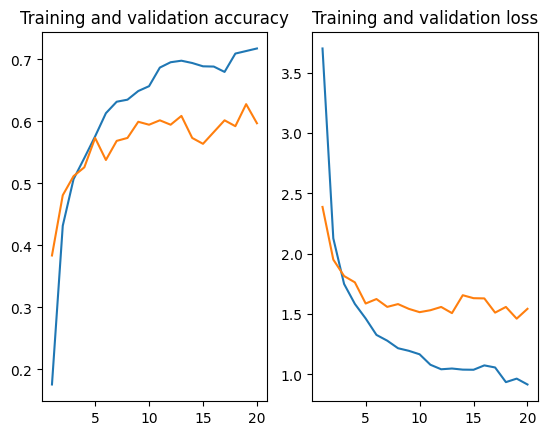

In [30]:
acc      = history_1.history['categorical_accuracy']
val_acc  = history_1.history['val_categorical_accuracy']
loss     = history_1.history['loss']
val_loss = history_1.history['val_loss' ]

epochs   = np.arange(len(acc)) + 1 # Get number of epochs

fig, (ax1,ax2) = plt.subplots(1,2)

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
ax1.plot  ( epochs,     acc )
ax1.plot  ( epochs, val_acc )
ax1.set_title ('Training and validation accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
ax2.plot  ( epochs,     loss )
ax2.plot  ( epochs, val_loss )
ax2.set_title ('Training and validation loss'   )

## Fine-tune, allow small number of final MobileNet layers to train

* see if can improve beyond val_acc ~0.60 simply by fine-tuning last layers of the mobilenetv2 model

* will take the best validation accuracy from the base model above, and try fine tuning with a smaller learning rate. The idea being that now that the final classifier layer is tuned to the current data set, we can make small needed adjustments to the pretrained weights in the final layers that were frozen before.  This is the advised strategy from tensorflow docs, see the "Fine Tuning" section: https://www.tensorflow.org/tutorials/images/transfer_learning




In [31]:
latest = tf.train.latest_checkpoint('training_1')
latest #filename of the latest checkpoint

# from manual inspection of val accuracy
best_epoch=19
best = os.path.join('training_1',f'cp-{best_epoch:04d}.ckpt')
best

'training_1/cp-0019.ckpt'

In [59]:
fine_tune_count = 4

fine_tune_name = 'mobilenet_finetune_'+str(fine_tune_count)

model_finetune = get_uncompiled_model(n_classes,model_name=fine_tune_name,fine_tune=fine_tune_count)
    
model_finetune.summary()

model_finetune.input

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 87)                111447    
                                                                 
Total params: 2,369,431
Trainable params: 523,607
Non-trainable params: 1,845,824
_________________________________________________________________


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [60]:
!rm -r training_2

!mkdir training_2

In [62]:
#start from checkpoint for best model 
model_finetune.load_weights(best)

fine_tune_lr = 0.003/5000

#use smaller learning rate for fine-tuning... 0.0001 
model_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [55]:
class AccCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('categorical_accuracy') >= 0.9):

      # Stop if threshold is met
      print("\nReached 0.8 target training accuracy")
      self.model.stop_training = True

# Instantiate class
train_acc_callback = AccCallback()

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [63]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

history_finetune = model_finetune.fit(
            train_generator,
            epochs=20,
            validation_data=val_generator,
            verbose=1,
            callbacks=[cp_callback,train_acc_callback,stop_callback]
            )

Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 5.6508 - categorical_accuracy: 0.2650
Epoch 1: saving model to training_2/cp-0001.ckpt
39/39 [==============================] - 43s 997ms/step - loss: 5.6508 - categorical_accuracy: 0.2650 - val_loss: 2.5357 - val_categorical_accuracy: 0.3957
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 2.2665 - categorical_accuracy: 0.4310
Epoch 2: saving model to training_2/cp-0002.ckpt
39/39 [==============================] - 37s 962ms/step - loss: 2.2665 - categorical_accuracy: 0.4310 - val_loss: 2.0674 - val_categorical_accuracy: 0.4787
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 1.7376 - categorical_accuracy: 0.5201
Epoch 3: saving model to training_2/cp-0003.ckpt
39/39 [==============================] - 38s 965ms/step - loss: 1.7376 - categorical_accuracy: 0.5201 - val_loss: 1.8610 - val_categorical_accuracy: 0.5308
Epoch 4/20
39/39 [==============================] - ETA: 0s - loss:

Text(0.5, 1.0, 'Training and validation loss')

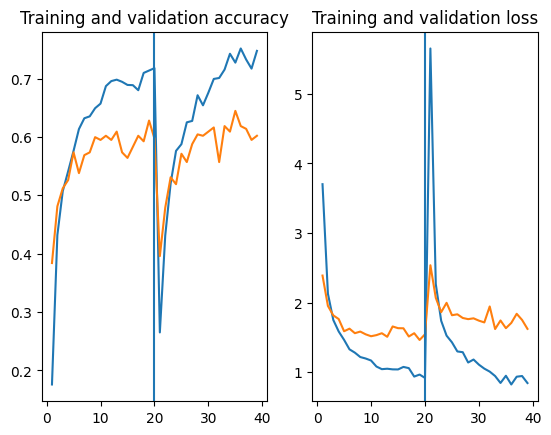

In [64]:
acc      += history_finetune.history['categorical_accuracy']
val_acc  += history_finetune.history['val_categorical_accuracy']
loss     += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss' ]

epochs   = np.arange(len(acc)) + 1 # Get number of epochs

fig, (ax1,ax2) = plt.subplots(1,2)

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
ax1.plot  ( epochs,     acc )
ax1.plot  ( epochs, val_acc )
ax1.axvline(20)
ax1.set_title ('Training and validation accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
ax2.plot  ( epochs,     loss )
ax2.plot  ( epochs, val_loss )
ax2.axvline(20)
ax2.set_title ('Training and validation loss'   )

In [65]:
model_finetune.layers[1].summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              